In [1]:
import tensorflow as tf
from keras.applications import VGG16
from PIL import Image
import numpy as np
from scipy.misc import imsave
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

/home/chawat/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 300; width = 400

In [3]:
c = np.array(Image.open("c.jpg").resize((width, height))).reshape(1, height, width, 3)
s = np.array(Image.open("s.jpg").resize((width, height))).reshape(1, height, width, 3)

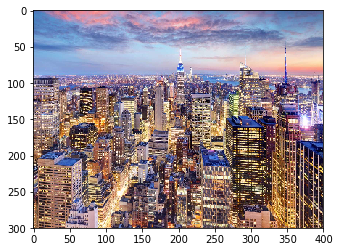

In [4]:
plt.imshow(c[0])

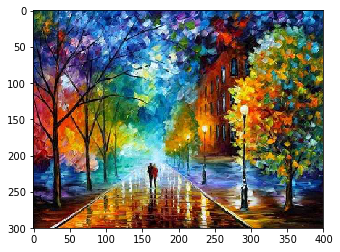

In [5]:
plt.imshow(s[0])

In [6]:
c = c[:, :, :, ::-1]
s = s[:, :, :, ::-1]

In [7]:
c[:, :, :, 0] -= 103
c[:, :, :, 1] -= 116
c[:, :, :, 2] -= 123
c = c[:, :, :, ::-1]

s[:, :, :, 0] -= 103
s[:, :, :, 1] -= 116
s[:, :, :, 2] -= 123
s = s[:, :, :, ::-1]

In [8]:
# C = tf.Variable(value = c, dtype = tf.float32)
# S = tf.Variable(value = s, dtype = tf.float32)
C = tf.constant(value= c, dtype = tf.float32)
S = tf.constant(value= s, dtype= tf.float32)

W = tf.Variable(initial_value= tf.random_uniform(maxval = 128, shape = (1, height, width, 3)))

In [9]:
Inp = tf.concat(values = [C, S, W], axis = 0)
# Inp = tf.placeholder(dtype = tf.float32, shape = (3, height, width, 3))

In [10]:
model = VGG16(include_top=False, input_tensor= Inp)

In [11]:
[layer.name for layer in model.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [12]:
Loss = 0.0

In [13]:
def content_loss():
    Out0 = model.get_layer(index = 9).output
    Out1 = model.get_layer(index = 4).output
    Out2 = model.get_layer(index = 5).output
    
#     H, W, C = Out[0].get_shape().as_list()
#     return K.sum(tf.square(K.reshape(Out[0], (1, H*W, C)) - K.reshape(Out[2], (1, H*W, C))))/
    return  2 * K.sum(tf.square(Out0[0] - Out0[2])) + 0.85 * K.sum(tf.square(Out1[0] - Out1[2])) + 0.8 * K.sum(tf.square(Out2[0] - Out2[2]))

In [14]:
Loss += 250 * content_loss()

In [15]:
# This function is taken from fchollet's implementation of neural style transfer.
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [16]:
def style_loss():
    Out1 = model.get_layer(index = 12).output
#     Out2 = model.get_layer(index = 14).output
    Out3 = model.get_layer(index = 3).output
#     Out4 = model.get_layer(index = 5).output
    Out5 = model.get_layer(index = 7).output
#     Out6 = model.get_layer(index = 9).output
    Out7 = model.get_layer(index = 15).output
    Out8 = model.get_layer(index = 17).output
    Out = [Out1, Out3, Out5, Out7, Out8]
    style = 0.0
    for i in range(len(Out)):
        style += K.sum(tf.square(gram_matrix(Out[i][1]) - gram_matrix(Out[i][2])))/(2 * (height * width) ** 2)
    
    return style

In [17]:
# Loss +=  10000 * style_loss()

In [18]:
grads = K.gradients(Loss, W)[0]

In [19]:
opt = tf.train.AdamOptimizer(learning_rate= 20)

In [20]:
train_ = opt.minimize(Loss, var_list=[W])

In [21]:
sess = tf.InteractiveSession()

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
def train( lr = 0.001, epochs = 1):
    global W
    x = sess.run(W)
    for e in range(epochs):
        _, loss = sess.run([train_, Loss])
        
        if e % 10 == 0:
            imsave("img_" + str(e) + "_.jpg", sess.run(W)[0])
            print("epoch {}, loss: {}".format(e, loss))
    return sess.run(W)[0]

In [24]:
img = train(lr = 45 , epochs = 45000)

/home/chawat/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


epoch 0, loss: 87726309376.0
epoch 10, loss: 17641871360.0
epoch 20, loss: 9163278336.0
epoch 30, loss: 6061173248.0
epoch 40, loss: 4446213120.0
epoch 50, loss: 3551146752.0
epoch 60, loss: 3001965056.0
epoch 70, loss: 2624482304.0
epoch 80, loss: 2345106432.0
epoch 90, loss: 2123421056.0
epoch 100, loss: 1943506432.0
epoch 110, loss: 1792856320.0
epoch 120, loss: 1663678720.0
epoch 130, loss: 1555700480.0


KeyboardInterrupt: 